##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [186]:
# %pip install pandas 
# %pip install matplotlib
#%pip install statsmodels
#%pip install seaborn
#%pip install scikit-learn
#%pip install mlxtend
#%pip install numpy
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [187]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

### Explore Percentage of Missing Values in Each Column

In [189]:
df = pd.read_csv(filepath)

df.isna().sum() / len(df) * 100

LATITUDE                                 0.411212
LONGITUDE                                0.411212
AccountID                                0.000000
Company                                  0.000000
SIC Code                                 0.000000
Industry                                 0.000000
8-Digit SIC Code                         0.000000
8-Digit SIC Description                  0.000000
Year Found                               1.487218
Entity Type                              0.000000
Parent Company                           1.761360
Parent Country                           1.781920
Ownership Type                           0.000000
Company Description                      0.000000
Square Footage                         100.000000
Company Status (Active/Inactive)         0.000000
Employees (Single Site)                 42.502227
Employees (Domestic Ultimate Total)      0.270715
Employees (Global Ultimate Total)        9.505860
Sales (Domestic Ultimate Total USD)      0.000000


### Exploring the Variable 'Year Found'

In [197]:
new_df = df.copy()

print(new_df['Year Found'].describe())

## Replace missing values in Year Found by the median 2008 
new_df['Year Found'] = new_df['Year Found'].fillna(2008)

#len(df.loc[df['Year Found']==2008]) #1116
#len(new_df.loc[new_df['Year Found']==2008]) #1550

count    28748.000000
mean      2004.505913
std         13.464238
min       1819.000000
25%       1997.000000
50%       2008.000000
75%       2014.000000
max       2023.000000
Name: Year Found, dtype: float64


### Exploring the Variable 'Employees (Domestic Ultimate Total)'

count    29103.000000
mean       139.764182
std       1118.939249
min          1.000000
25%          4.000000
50%         16.000000
75%         60.000000
max      80000.000000
Name: Employees (Domestic Ultimate Total), dtype: float64
Axes(0.125,0.11;0.775x0.77)


,Employees (Domestic Ultimate Total),Employees (Single Site)
Employees (Domestic Ultimate Total),1.000000,0.139117
Employees (Single Site),0.139117,1.000000


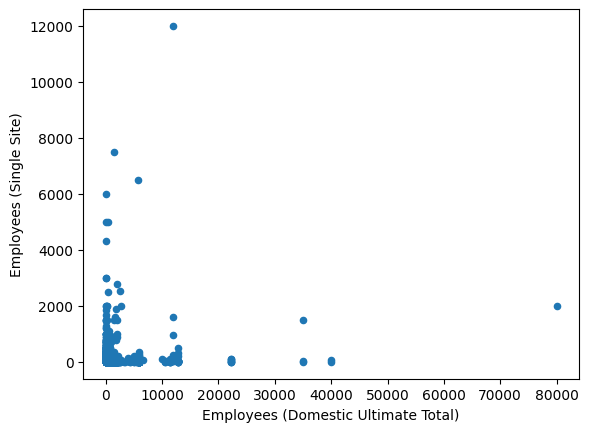

In [203]:
print(new_df['Employees (Domestic Ultimate Total)'].describe()) #mean = 139.764182

print(df.plot.scatter(x = 'Employees (Domestic Ultimate Total)', y = 'Employees (Single Site)'))

df[['Employees (Domestic Ultimate Total)', 'Employees (Single Site)']].corr()

#### Imputation of 'Employees (Domestic Ultimate Total)

In [204]:
#TODO: Correct imputation with regression outputs

## Run OLS on Employees (Domestic Ultimate Total) using Emplyees (Single Site)
result = sm.ols(formula="df['Employees (Domestic Ultimate Total)'] ~ df['Employees (Single Site)']", data=df).fit()
print(result.summary()) # Results are significant

# the result is significant, so can replace missing values with Employees (Single Site)
new_df['Employees (Domestic Ultimate Total)']= new_df['Employees (Domestic Ultimate Total)'].fillna(new_df['Employees (Single Site)'])

# Only five rows where we cannot replace with Employees (Single Site) -> remove these rows?
new_df.loc[new_df['Employees (Domestic Ultimate Total)'].isna()][['Employees (Single Site)','Employees (Domestic Ultimate Total)']]  


                                        OLS Regression Results                                       
Dep. Variable:     df['Employees (Domestic Ultimate Total)']   R-squared:                       0.019
Model:                                                   OLS   Adj. R-squared:                  0.019
Method:                                        Least Squares   F-statistic:                     329.6
Date:                                       Sun, 28 Jan 2024   Prob (F-statistic):           5.79e-73
Time:                                               23:48:00   Log-Likelihood:            -1.4246e+05
No. Observations:                                      16705   AIC:                         2.849e+05
Df Residuals:                                          16703   BIC:                         2.849e+05
Df Model:                                                  1                                         
Covariance Type:                                   nonrobust                      

,Employees (Single Site),Employees (Domestic Ultimate Total)
7727,NaN,NaN
10768,NaN,NaN
16455,NaN,NaN
20822,NaN,NaN
22660,NaN,NaN


### Exploring 'SIC Code' and Binning it into 'Industrys'

In [205]:
# Convert SIC Code into Industrys and add a new column to the new_df
industry_mapping = {
    (101, 999): 'Agriculture',
    (1002, 1499): 'Mining',
    (1500, 1799): 'Construction',
    (2000, 3999): 'Manufacturing',
    (4000, 4999): 'Transportation',
    (5000, 5199): 'Wholesales',
    (5200, 5999): 'Retail',
    (6000, 6799): 'Finance',
    (7000, 8999): 'Services',
    (9000, 9899): 'Public',
    (9900, 10000): 'Others'
}
def map_to_industry(sic_code):
    for code_range, industry in industry_mapping.items():
        if code_range[0] < sic_code <= code_range[1]:
            return industry
    return 'Other'

# Create a new column 'Industry' based on the mapping
new_df['Industrys'] = new_df['SIC Code'].map(map_to_industry)

#### Exploring 'Industrys'

,Import/Export Status,Sales (Domestic Ultimate Total USD)
Import/Export Status,1.000000,-0.005679
Sales (Domestic Ultimate Total USD),-0.005679,1.000000


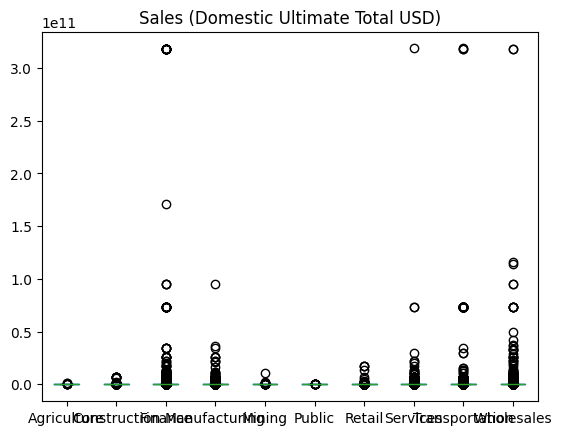

In [207]:
# Plot Sales (Domestic Ultimate Total USD) vs Industrys
new_df.plot.box(by = 'Industrys',column = 'Sales (Domestic Ultimate Total USD)')
#test correlation between 'import/export status' and 'sales (domestic ultimate total)'
df_import = new_df.copy()

# Simple assumption that BLANK in import/export means NEITHER
#if import/export status is NaN replace with 0, otherwise 1
df_import['Import/Export Status']=df_import['Import/Export Status'].fillna(0).map(lambda x:0 if x==0 else 1)
df_import[['Import/Export Status','Sales (Domestic Ultimate Total USD)']].corr()


# To do 
# MAKE BARPLOT OF SALES AGAINST IMPORT, EXPORT, IMPORT/EXPORT, and NAN 


In [208]:

variables_to_remove = [
    'AccountID', 'Company', '8-Digit SIC Code',
    'Parent Country', 'Import/Export Status', 'Domestic Ultimate Company',
    '8-Digit SIC Description', 'Company Description', 'Company Status (Active/Inactive)',
    'Fiscal Year End', 'Global Ultimate Company',
    'Global Ultimate Country','Parent Company', 'SIC Code', 'Industry', 'Square Footage'
]

df = new_df.drop(variables_to_remove, axis=1)
df.head()
#Drop remaining na rows
df = df.dropna()
print(len(df))
print(df.isna().sum() / len(df) * 100)

14605
LATITUDE                               0.0
LONGITUDE                              0.0
Year Found                             0.0
Entity Type                            0.0
Ownership Type                         0.0
Employees (Single Site)                0.0
Employees (Domestic Ultimate Total)    0.0
Employees (Global Ultimate Total)      0.0
Sales (Domestic Ultimate Total USD)    0.0
Sales (Global Ultimate Total USD)      0.0
Is Domestic Ultimate                   0.0
Is Global Ultimate                     0.0
Industrys                              0.0
dtype: float64


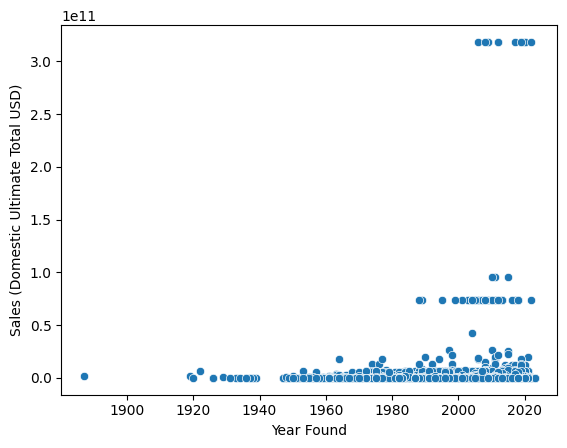

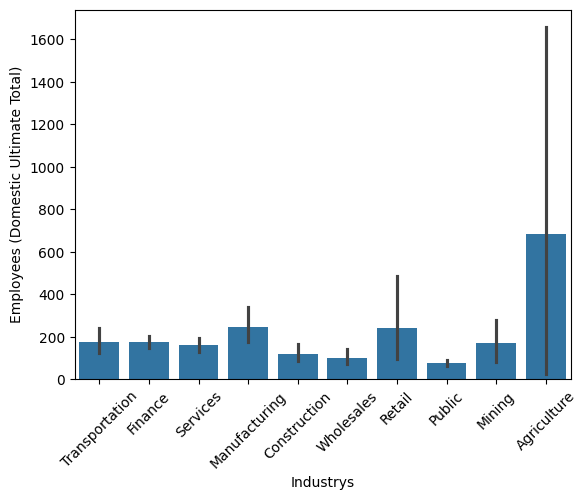

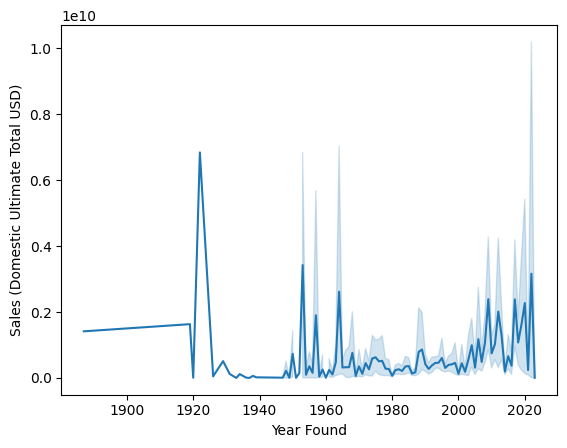

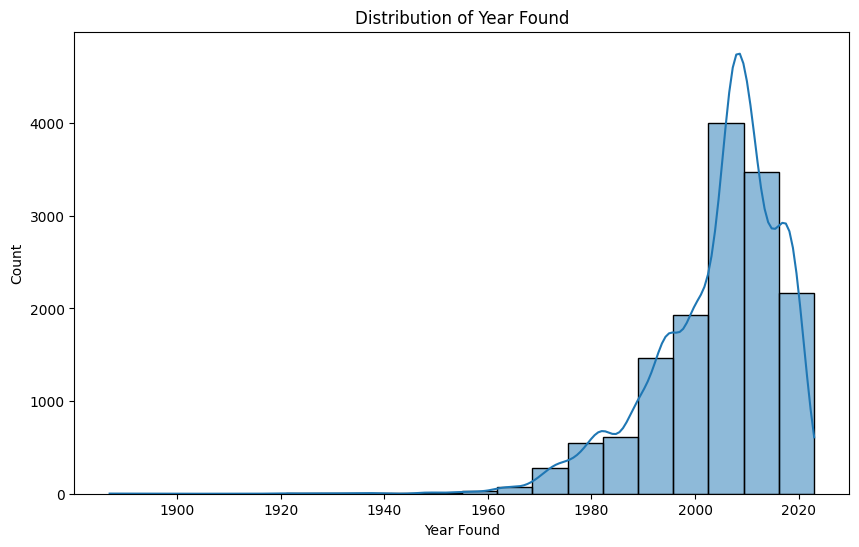

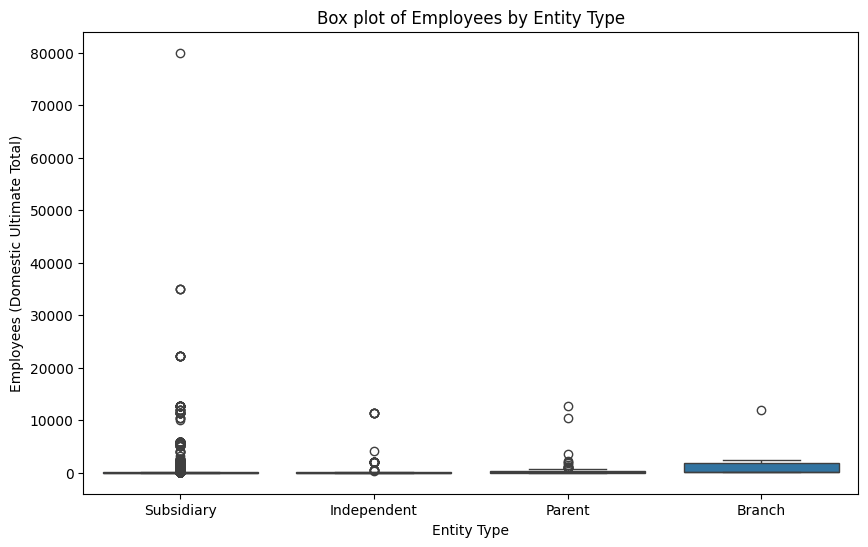

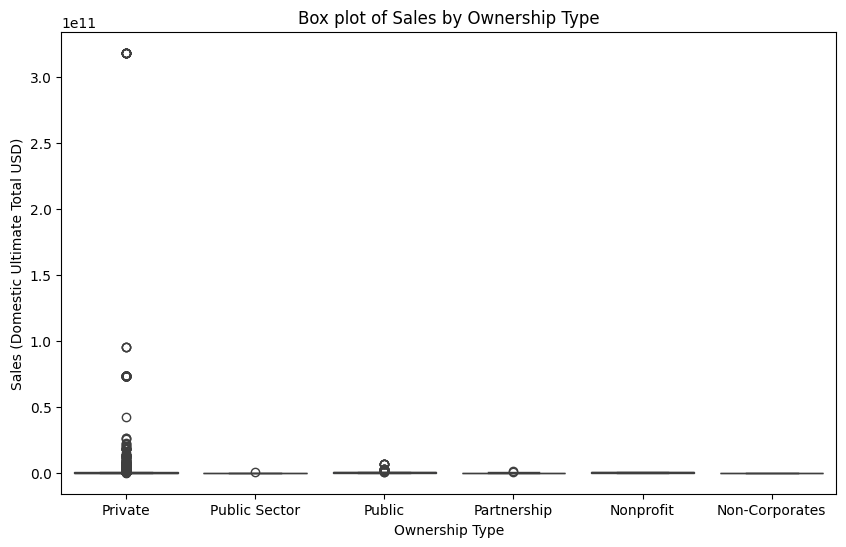

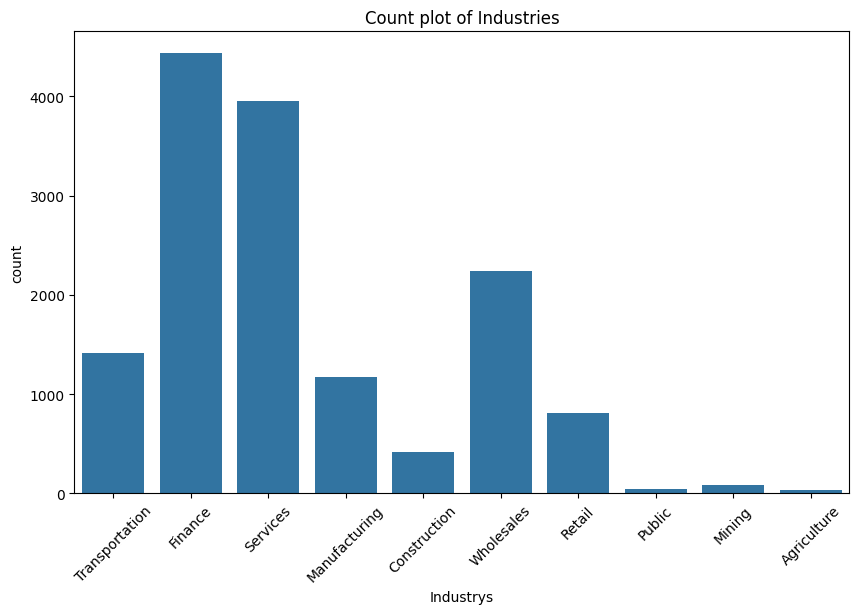

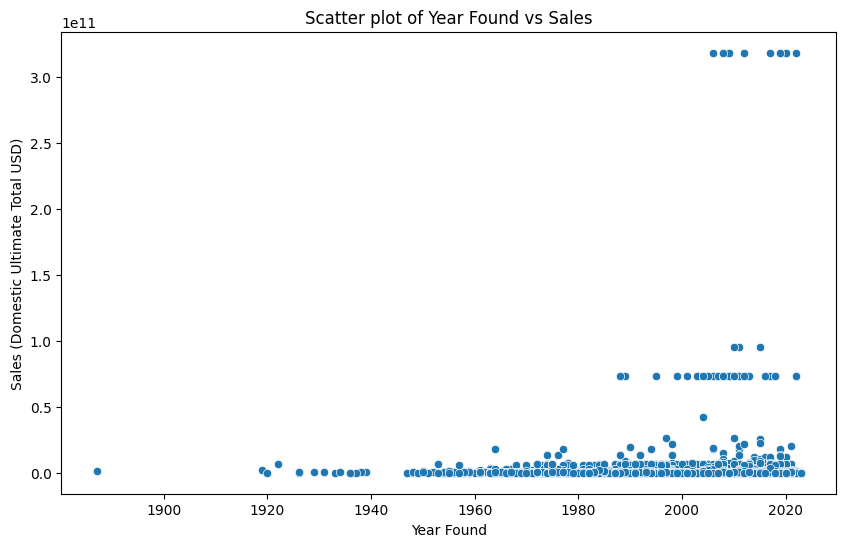

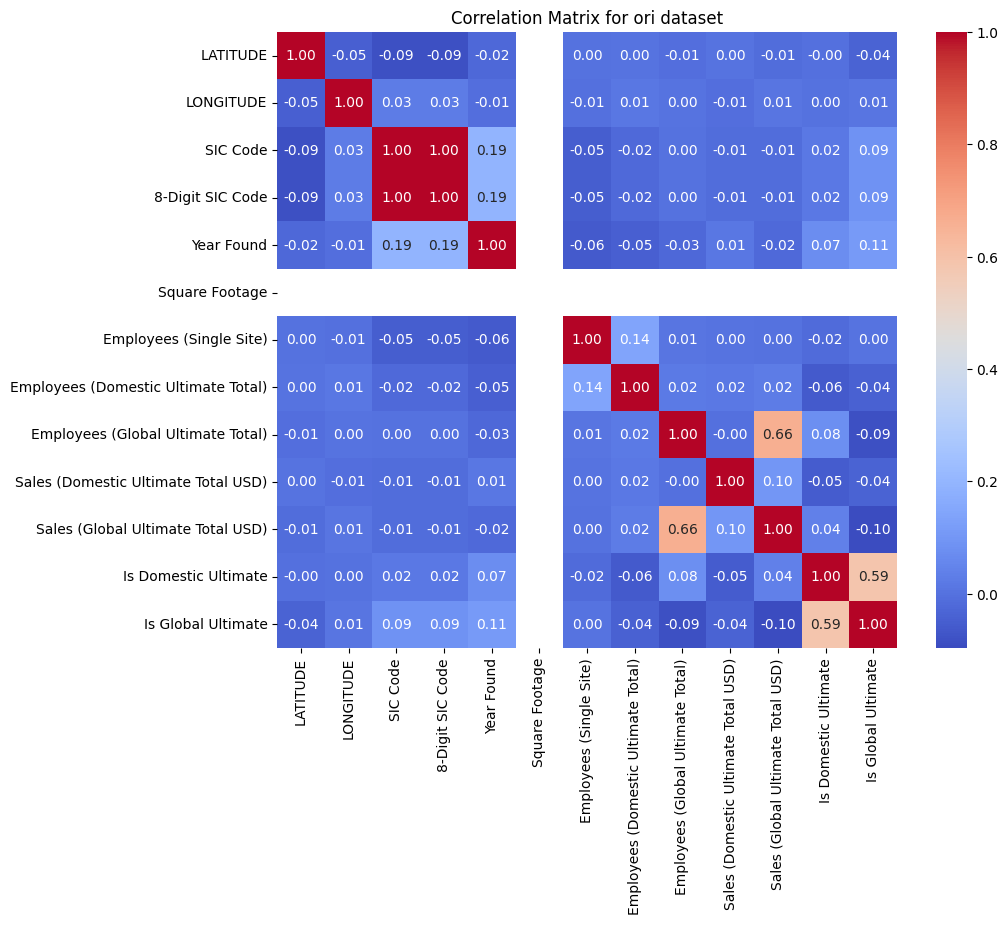

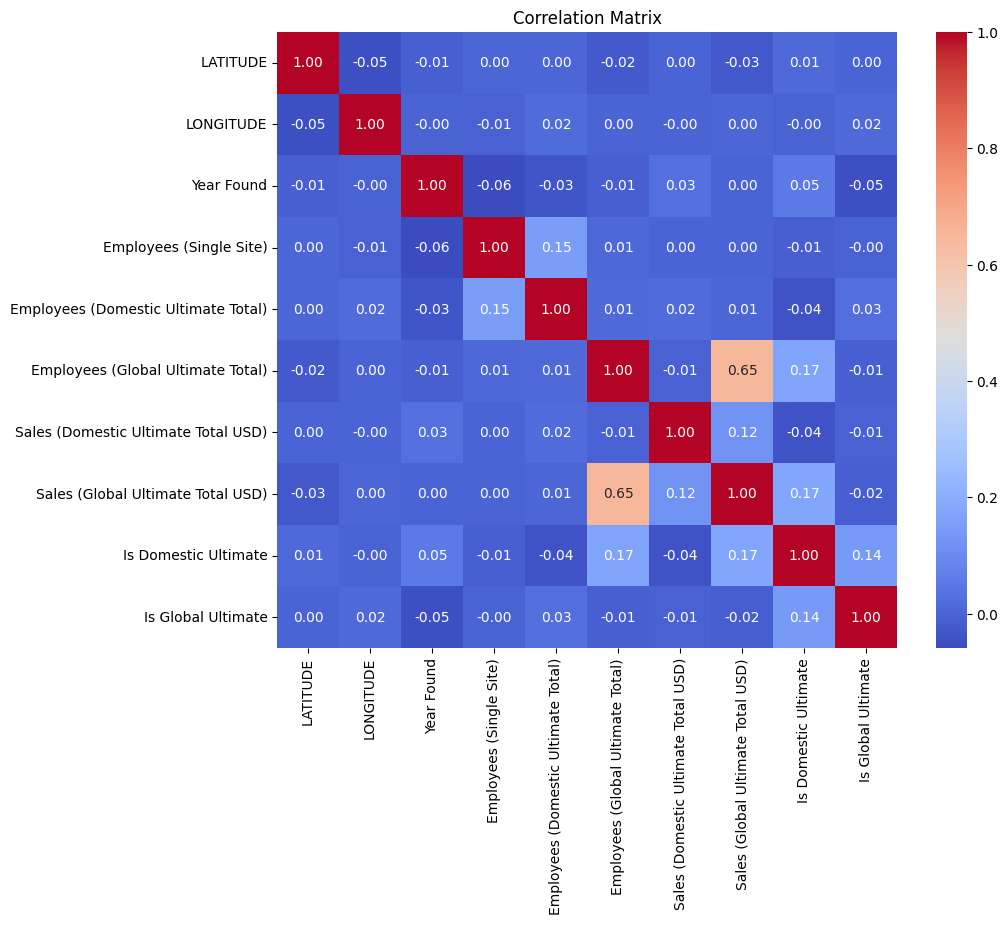

In [209]:
#To do -> look at the error in plots 

variables = df.columns

# Creating scatter plots
# for i in range(len(variables)):
#     for j in range(i + 1, len(variables)):
#         try:
#             plt.scatter(df[variables[i]], df[variables[j]])
#             plt.title(f'{variables[i]} vs {variables[j]}')
#             plt.xlabel(variables[i])
#             plt.ylabel(variables[j])
#             plt.show()
#         except Exception as e:
#             print(f"Error plotting {variables[i]} vs {variables[j]}: {e}")

sns.scatterplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.show()

# Grouped Analysis
sns.barplot(x='Industrys', y='Employees (Domestic Ultimate Total)', data=df)
plt.xticks(rotation=45)
plt.show()

# Time Series Analysis
sns.lineplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Year Found'], bins=20, kde=True)
plt.title('Distribution of Year Found')
plt.show()

# # Explore the distribution of 'Employees'
# plt.figure(figsize=(10, 6))
# sns.histplot(df['Employees (Domestic Ultimate Total)'], bins=20, kde=True)
# plt.title('Distribution of Employees')
# plt.show()

# # Explore the distribution of 'Sales'
# plt.figure(figsize=(10, 6))
# sns.histplot(df['Sales (Domestic Ultimate Total USD)'], bins=20, kde=True)
# plt.title('Distribution of Sales')
# plt.show()

# Box plot for 'Employees' by 'Entity Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Entity Type', y='Employees (Domestic Ultimate Total)', data=df)
plt.title('Box plot of Employees by Entity Type')
plt.show()

# Box plot for 'Sales' by 'Ownership Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ownership Type', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.title('Box plot of Sales by Ownership Type')
plt.show()

# Count plot for 'Industrys'
plt.figure(figsize=(10, 6))
sns.countplot(x='Industrys', data=df)
plt.title('Count plot of Industries')
plt.xticks(rotation=45)
plt.show()

# Scatter plot for 'Year Found' vs 'Sales'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year Found', y='Sales (Domestic Ultimate Total USD)', data=df)
plt.title('Scatter plot of Year Found vs Sales')
plt.show()

numeric_columns = new_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = new_df[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for ori dataset')
plt.show()

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

One-Hot Encoding

In [210]:
df_copy = df.copy()
print(df_copy)
# df_copy = df_copy.drop(['Sales (Domestic Ultimate Total USD)'],axis=1)

#df=df.join(pd.get_dummies(df.Industrys))
df_copy=pd.get_dummies(df_copy, columns=['Industrys'],drop_first=True)
df_copy=pd.get_dummies(df_copy, columns=['Entity Type'],drop_first=True)
df_copy=pd.get_dummies(df_copy, columns=['Ownership Type'],drop_first=True)

df_copy.columns = df_copy.columns.str.replace('Industrys_', '')
df_copy.columns = df_copy.columns.str.replace('Entity Type_', '')
df_copy.columns = df_copy.columns.str.replace('Ownership Type_', '')
# df_copy = df_copy.dropna()
print(df_copy)

       LATITUDE   LONGITUDE  Year Found Entity Type Ownership Type  \
1      1.291294  103.827476      2015.0  Subsidiary        Private   
2      1.300144  103.857517      1993.0  Subsidiary        Private   
3      1.300785  103.791263      2006.0  Subsidiary        Private   
5      1.444773  103.812740      1986.0  Subsidiary        Private   
7      1.282887  103.850849      2010.0  Subsidiary        Private   
...         ...         ...         ...         ...            ...   
29171  1.274915  103.799145      2020.0  Subsidiary        Private   
29175  1.292221  103.850613      2009.0  Subsidiary        Private   
29176  1.277753  103.848429      1996.0  Subsidiary        Private   
29180  1.295595  103.858968      2018.0  Subsidiary        Private   
29181  1.311769  103.801710      2018.0  Subsidiary        Private   

       Employees (Single Site)  Employees (Domestic Ultimate Total)  \
1                         39.0                                100.0   
2                

FEATURE SELECTION (STEPWISE)

In [29]:
df_copy2 = df_copy
# print(df_copy2)
# Define your predictors and response variable
y = df_copy2['Sales (Domestic Ultimate Total USD)']
X = df_copy2.drop('Sales (Domestic Ultimate Total USD)', axis = 1)

#y = df_copy2['Sales (Domestic Ultimate Total USD)']
#df_copy2 = df_copy2.dropna()

print(X)
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize Linear Regression model
lr = LinearRegression()

# Initialize SequentialFeatureSelector
sfs = SFS(lr, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

# Perform SFS
sfs = sfs.fit(X_train, y_train)

# Print the selected feature indices and names
selected_features_indices = sfs.k_feature_idx_
selected_features_names = X.columns[list(selected_features_indices)]

print('Selected features indices:', selected_features_indices)
print('Selected features names:', selected_features_names)

       LATITUDE   LONGITUDE  Year Found  Employees (Single Site)  \
1      1.291294  103.827476      2015.0                     39.0   
2      1.300144  103.857517      1993.0                      4.0   
3      1.300785  103.791263      2006.0                     10.0   
5      1.444773  103.812740      1986.0                    300.0   
7      1.282887  103.850849      2010.0                     10.0   
...         ...         ...         ...                      ...   
29171  1.274915  103.799145      2020.0                     10.0   
29175  1.292221  103.850613      2009.0                     25.0   
29176  1.277753  103.848429      1996.0                    100.0   
29180  1.295595  103.858968      2018.0                     10.0   
29181  1.311769  103.801710      2018.0                     11.0   

       Employees (Domestic Ultimate Total)  Employees (Global Ultimate Total)  \
1                                    100.0                              100.0   
2                    

c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\tansi\miniconda3\envs\SDSDatathon\lib\site-

Selected features indices: (2, 4, 5, 6, 7, 8, 10, 16, 17, 18, 23)
Selected features names: Index(['Year Found', 'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Global Ultimate Total USD)', 'Is Domestic Ultimate',
       'Is Global Ultimate', 'Finance', 'Transportation', 'Wholesales',
       'Independent', 'Private'],
      dtype='object')


Linear Regression Model

In [12]:
lr = LinearRegression()
# Fit the model with selected features
lr.fit(X_train[selected_features_names], y_train)

# Make predictions using your trained model
y_pred = lr.predict(X_test[selected_features_names])

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

NameError: name 'mean_absolute_error' is not defined

Gradient Boosting

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

# Lists to store results
n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

# # Iterate over different numbers of folds
# for n_folds in n_folds_values:
#     # Use k-fold cross-validation with the current number of folds
#     kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

#     # Perform cross-validation and get R-squared scores
#     cv_scores = cross_val_score(model, X_train[selected_features_names], y_train, cv=kf, scoring='r2')

#     # Append mean and standard deviation of R-squared scores to lists
#     mean_r2_scores.append(cv_scores.mean())
#     std_r2_scores.append(cv_scores.std())

# # Plot the results
# plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
# plt.xlabel('Number of Folds')
# plt.ylabel('R-squared Score')
# plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
# plt.legend()
# plt.show()
    
# Use k-fold cross-validation with 10 folds
model_10 = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model, X_train[selected_features_names], y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
model_10.fit(X_train[selected_features_names], y_train)

# Evaluate the model on the test set
test_score = model_10.score(X_test[selected_features_names], y_test)
print("Test R-squared score:", test_score)

Cross-Validation R-squared scores: [ 0.40931557  0.33960491 -0.16566598  0.27058541  0.33278932  0.30436996
  0.43698178  0.30466885  0.35427189  0.39313436]
Mean R-squared score: 0.29800560589806313
Standard Deviation of R-squared scores: 0.16207658102565384
Test R-squared score: 0.4435573834871407


MODEL SELECTION



In [14]:
from sklearn.decomposition import PCA

                                          PC0       PC1       PC2       PC3  \
LATITUDE                            -0.017392  0.002102 -0.001987  0.171039   
LONGITUDE                            0.014148  0.005377  0.009405  0.006756   
Year Found                          -0.048730 -0.055590  0.005258  0.098579   
Employees (Single Site)              0.021994  0.024300  0.008014  0.035769   
Employees (Domestic Ultimate Total)  0.035350 -0.014149 -0.013087  0.025829   
Employees (Global Ultimate Total)    0.015892 -0.171159  0.615045 -0.076625   
Sales (Domestic Ultimate Total USD) -0.010484 -0.009682  0.073631 -0.044961   
Sales (Global Ultimate Total USD)    0.008038 -0.165022  0.624981 -0.100915   
Is Domestic Ultimate                 0.079676 -0.146035  0.302868 -0.045907   
Is Global Ultimate                   0.494023 -0.160497 -0.091502 -0.123820   
Construction                        -0.017517  0.007678 -0.046331  0.025020   
Finance                              0.048063  0.084

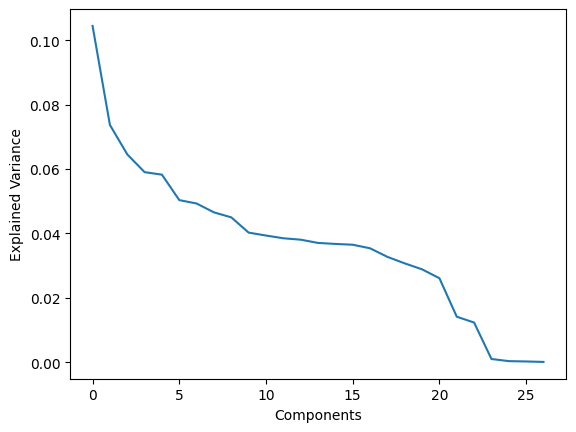

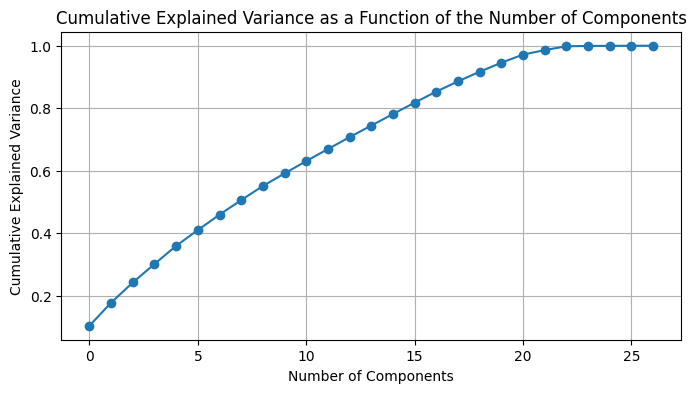

In [15]:
df_copy2 = df_copy.copy()

df_normalized=(df_copy - df_copy.mean()) / df_copy.std()
pca = PCA(n_components=df_copy.shape[1])
#pca.fit(df_normalized)
pca.fit(df_normalized)


loadings = pd.DataFrame(pca.components_.T, columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],index=df_normalized.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

# Calculate the cumulative variance explained by each component
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.grid(True)
plt.show()

   LATITUDE   LONGITUDE  Year Found Entity Type Ownership Type  \
1  1.291294  103.827476      2015.0  Subsidiary        Private   
2  1.300144  103.857517      1993.0  Subsidiary        Private   
3  1.300785  103.791263      2006.0  Subsidiary        Private   
5  1.444773  103.812740      1986.0  Subsidiary        Private   
7  1.282887  103.850849      2010.0  Subsidiary        Private   

   Employees (Single Site)  Employees (Domestic Ultimate Total)  \
1                     39.0                                100.0   
2                      4.0                                  4.0   
3                     10.0                                100.0   
5                    300.0                                  4.0   
7                     10.0                                  4.0   

   Employees (Global Ultimate Total)  Sales (Domestic Ultimate Total USD)  \
1                              100.0                         7.093536e+09   
2                                4.0          

C:\Users\tansi\AppData\Local\Temp\ipykernel_3432\1006481656.py:33: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
C:\Users\tansi\AppData\Local\Temp\ipykernel_3432\1006481656.py:38: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score = -1*model_selection.cross_val_score(regr, X_train_pca[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
C:\Users\tansi\AppData\Local\Temp\ipykernel_3432\1006481656.py:38: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  score = -1*model_selection.cr

[[-6.78699546e-02 -3.19602748e-01  1.38083850e+00 ...  3.68603317e-03
   3.44936370e-03 -1.48037143e-16]
 [-3.49711580e-01 -8.74441201e-02 -3.70136991e-01 ... -3.41741799e-03
  -2.09265918e-03  6.70776846e-17]
 [-2.87304957e-01  2.32578268e-01 -6.85159605e-01 ...  5.69732873e-04
  -4.95646515e-03  2.58338003e-16]
 ...
 [-1.57062108e-01 -6.37395252e-01  2.27948820e+00 ...  8.55269047e-04
   9.68260772e-04  9.01448997e-18]
 [-2.20939264e-01 -2.98586699e-01  5.25128906e-01 ...  2.07397732e-03
  -8.23514771e-03  7.30623796e-18]
 [-3.49673674e-01 -9.92361723e-02 -3.64590834e-01 ... -3.47929097e-03
  -5.73917844e-04 -2.39884028e-18]]
Mean Squared Error: 4.595545171481059e+19
R^2 Score: 0.0378734359981171


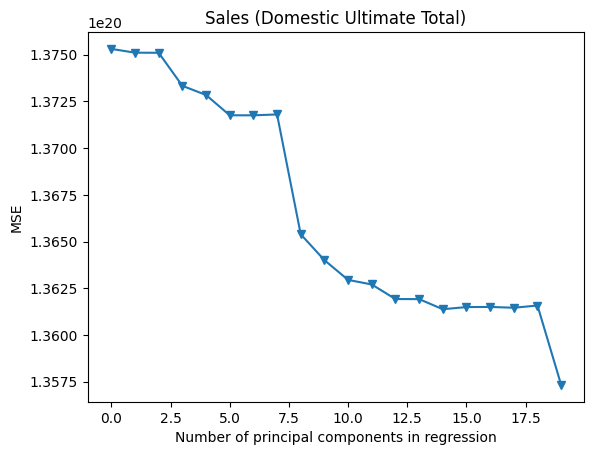

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

print(df.head())
# Assuming df_copy is your DataFrame and 'Sales (Total Domestic USD)' is your target variable
X = df_copy2
y = df.dropna()['Sales (Domestic Ultimate Total USD)']

# Standardize the data (if not already done)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Select the number of components based on cumulative variance plot + 10-Fold cross validation 

# 10-fold CV, with shuffle
n = len(X_train_pca)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_train_pca[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Sales (Domestic Ultimate Total)')
plt.xlim(xmin=-1)

# Pick 13 components 
n_components = 13
print(X_train_pca)
# Regression Model
regressor = LinearRegression()
regressor.fit(X_train_pca, y_train)

# Predictions
y_pred = regressor.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [28]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [29]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!